# Coding Assignment I - Scratch Implementation of Gaussian Mixture Models 
---
### Itzhak Estrella (ie2864)

In [126]:
# import all necessary libraries
import numpy as np                             # for numerical computation 
from scipy.stats import multivariate_normal    # for multivariate normal distribution
from sklearn.mixture import GaussianMixture    
from sklearn.decomposition import PCA          
from sklearn.datasets import load_wine
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt                # for plotting
from mpl_toolkits.mplot3d import Axes3D        # for 3D plotting
import warnings                                # to ignore warnings
warnings.filterwarnings("ignore")

SEED = 100                                     # seed for reproducibility

#### Gaussian Probability Density Function
Now lets implement the Gaussian probability density function which is as follows:
$$p(\mathbf x | \mathbf\mu, \mathbf\Sigma) = \frac 1 {\sqrt{({2\pi})^{D} \cdot|\Sigma|}}\exp\left(-\frac 1 2 (\mathbf x -\mathbf\mu)^T \cdot \mathbf\Sigma^{-1} \cdot (\mathbf x -\mathbf\mu)\right)$$
However, to make our lives easier, we can use the `mulitvariate_normal` built-in function from the `scipy.stats` library to calculate the Gaussian probability density function.

In [127]:
def Gaussian_pdf(samples, mu, sigma):
    '''
    computation for the Gaussian probability density function for a given data sample

    Parameters:
    - samples: the samples for which the probability density function is to be computed <numpy array>
    '''
    return multivariate_normal.pdf(samples, mean=mu, cov=sigma, allow_singular=True)


#### Expectation Implementation (E-step)
The E-step is the first step in the EM algorithm. In this step, we calculate the responsibilities of each component for each data point. The responsibilities are calculated using the following formula:
$$\gamma(z_{nk}) = \frac{\pi_k \cdot p(\mathbf x_n | \mathbf\mu_k, \mathbf\Sigma_k)}{\sum_{j=1}^{K} \pi_j \cdot p(\mathbf x_n | \mathbf\mu_j, \mathbf\Sigma_j)}$$


In [128]:
def e_step(samples, mu, sigma, pi):
    '''
    expectation step in the EM algorithm, will output the posterior probabilities of the samples

    Parameters:
    - samples: d^2 dataset                                    <numpy array>
    - mu: the mean of the Gaussian components                 <numpy array>
    - sigma: the covariance matrix of the Gaussian components <numpy array>
    - pi: the mixing coefficients of the Gaussian components  <numpy array>
    '''
    n = samples.shape[0] # number of samples
    K = len(mu)          # number of components
    posterior_probabilities = np.zeros((n, K)) 
    # iterate over the components and compute the posterior probabilities
    for k, (mu_k, sigma_k) in enumerate(zip(mu, sigma)): 
        posterior_probabilities[:, k] = Gaussian_pdf(samples, mu_k, sigma_k) * pi[k]
    posterior_probabilities /= posterior_probabilities.sum(axis=1)[:, np.newaxis] # normalize
    return posterior_probabilities

#### Maximization Implementation (M-step)
The M-step is the second step in the EM algorithm. In this step, we update the parameters of the model using the posterior probabilities calculated in the E-step. The parameters are updated using the following formulas:
$$\pi_k^* = \frac 1 N \cdot N_k$$
$$\mu_k^* = \frac 1 {N_k} \sum_{n=1}^{N} \gamma(z_{nk}) \cdot \mathbf x_n$$
$$\Sigma_k^* = \frac 1 {N_k} \sum_{n=1}^{N} \gamma(z_{nk}) \cdot (\mathbf x_n - \mathbf\mu_k) \cdot (\mathbf x_n - \mathbf\mu_k)^T$$

where $N_k = \sum_{n=1}^{N} \gamma(z_{nk})$ is the effective number of points assigned to cluster $k$.


In [129]:
def m_step(samples, posterior_probabilities):
    '''
    maximization step in the EM algorithm, will output the updated parameters of the Gaussian components

    Parameters:
    - samples: d^2 dataset                                                <numpy array>
    - posterior_probabilities: the posterior probabilities of the samples <numpy array>
    '''
    n = samples.shape[0] # number of samples
    effective_component_counts = posterior_probabilities.sum(axis=0) # sum of the posterior probabilities for each component
    pi = effective_component_counts / n # update the priors based on the effective component counts
    mu = np.dot(posterior_probabilities.T, samples) / effective_component_counts[:, np.newaxis] # update the means
    sigma = list()
    # iterate over the components to update the covariance matrices
    for k in range(len(effective_component_counts)):
        diff = samples - mu[k]
        cov = np.dot(posterior_probabilities[:, k] * diff.T, diff) / effective_component_counts[k]
        sigma.append(cov)
    return mu, sigma, pi

### EM Mechanics
Finally, let's put everything together (build our EM mechanics). We will begin by initializing the parameters to random values and then perform several EM steps. In my case, my EM algorithm will terminate after a number of iterations of the training procedure which is defined by the fixed variable `max-iters`. 

In [130]:
# EM Mechanics
def gmm_em(samples, k_components, max_iter=100):
    '''
    Gaussian Mixture Model using the Expectation-Maximization algorithm, will output the global 
    optimal parameters of the Gaussian components
    
    Parameters:
    - samples: d^2 dataset                                         <numpy array>
    - k_components: number of components (aka clusters)            <int>
    - max_iter: maximum number of iterations to converge algorithm <int>
    '''
    np.random.seed(SEED)
    # initialize parameters randomly and uniformly
    n_samples = samples.shape[0]
    mu0 = samples[np.random.choice(n_samples, k_components, False)]
    sigma0 = [np.cov(samples, rowvar=False) for _ in range(k_components)]
    pi0 = np.ones(k_components) / k_components

    for _ in range(max_iter):
        posterior_probabilities = e_step(samples, mu0, sigma0, pi0) # E-step
        mu0, sigma0, pi0 = m_step(samples, posterior_probabilities) # M-step
    
    return mu0, sigma0, pi0

### Predict Function
Last but not least, we will implement a predict function that will compute both soft and hard cluster assignments for the data points. The soft cluster assignment is given by the responsibilities calculated in the E-step, while the hard cluster assignment is given by the cluster with the highest responsibility for each data point.

In [131]:
def predict(samples, mu, sigma, pi, soft=True):
    '''
    returns soft or hard assignments of of all samples in each component

    Parameters:
    - samples: d^2 dataset                                                        <numpy array>
    - mu: the mean of the Gaussian components                                     <numpy array>
    - sigma: the covariance matrix of the Gaussian components                     <numpy array>
    - pi: the mixing coefficients of the Gaussian components                      <numpy array>
    - soft: if True, returns the soft assignments, otherwise the hard assignments <bool>
    '''
    n = samples.shape[0] # number of samples
    K = len(mu)          # number of components
    
    likelihood = np.zeros((n, K))
    # compute the likelihood of each sample in each component
    for k in range(K):
        distribution_k = multivariate_normal(mean=mu[k], cov=sigma[k], allow_singular=True)
        likelihood[:, k] = distribution_k.pdf(samples)

    probabilities = (likelihood * pi) / ((likelihood * pi).sum(axis=1, keepdims=True))

    if soft:
        return probabilities / np.sum(probabilities)
    else:
        return np.argmax(probabilities, axis=1)

### Testing and Comparing our Model Implementation with Wine Dataset
---
For the last portion of this coding assignment, I will test my implementation of the Gaussian Mixture Model on the Wine dataset. I will also compare the results of my implementation with the built-in `GaussianMixture` model from the `sklearn` library. Visualizations will be provided to compare the results of both models; we will compare both soft and hard clustering results.

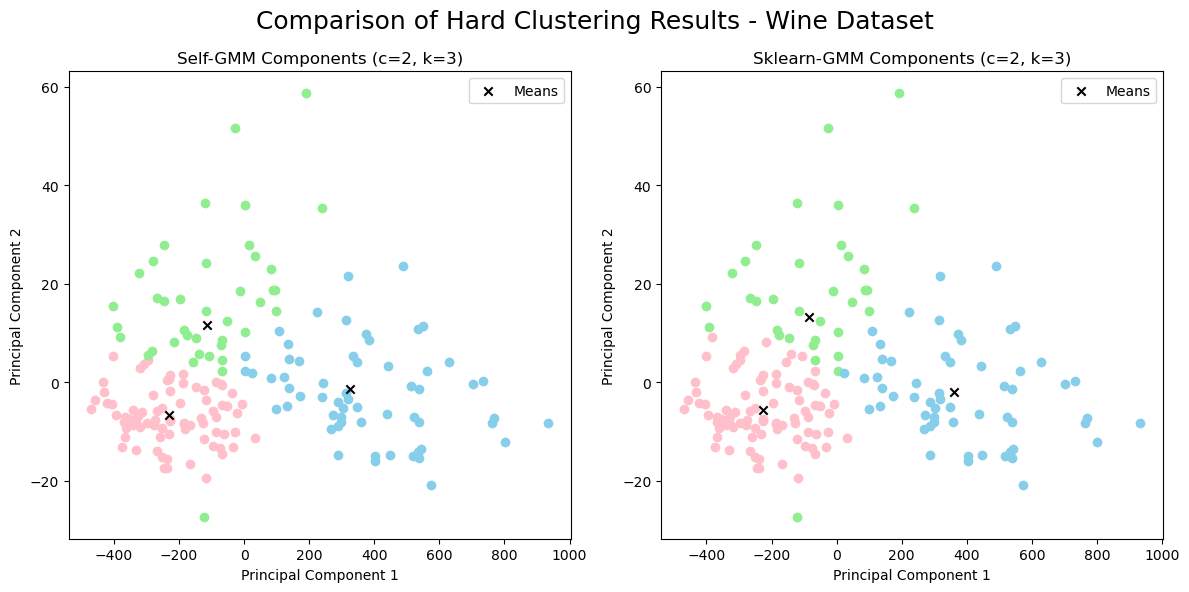

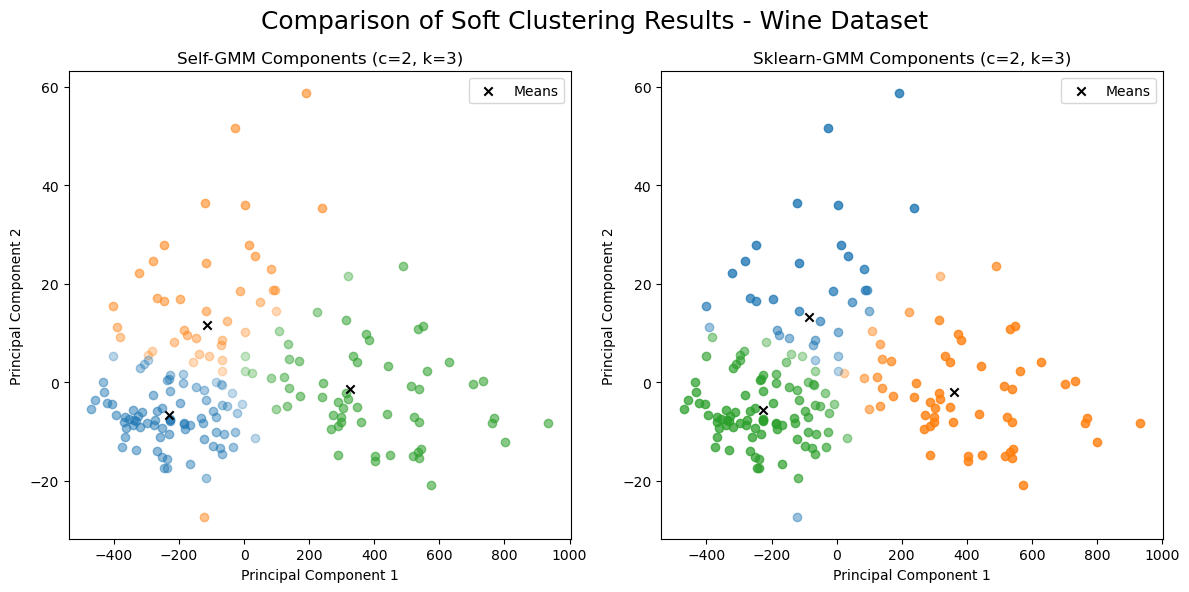

In [132]:
# load wine dataset
wine_data = load_wine()
X = wine_data.data
y = wine_data.target

# preprocess the dataset using PCA (from sklearn)
n_components_pca = 2 
pca = PCA(n_components=n_components_pca)
X_pca = pca.fit_transform(X)

# apply our defined GMM on preprocessed data
k_components_gmm = len(np.unique(y)) # find the number of unique classes to determine the number of components
# 0 = {pi, mu, sigma}
mu0, sigma0, pi0 = gmm_em(X_pca, k_components_gmm) 
hard_assignments = predict(X_pca, mu0, sigma0, pi0, soft=False) # hard clusters
soft_assignments = predict(X_pca, mu0, sigma0, pi0, soft=True)  # soft clusters

# apply sklearn's GMM on preprocessed data
gmm = GaussianMixture(n_components=k_components_gmm, random_state=SEED)
gmm.fit(X_pca)
hard_clusters = gmm.predict(X_pca)       # hard clusters
soft_clusters = gmm.predict_proba(X_pca) # soft clusters

#---------------------------------Hard Clustering Visualizations---------------------------------#
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
colors = ['pink', 'lightgreen', 'skyblue', 'red']
fig.suptitle('Comparison of Hard Clustering Results - Wine Dataset', fontsize=18)

# plot for my defined GMM
for k in range(k_components_gmm):
    mask = hard_assignments == k
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], color=colors[k])
axes[0].scatter(mu0[:, 0], mu0[:, 1], color='black', marker='x', label='Means')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].set_title('Self-GMM Components (c=2, k=3)')
axes[0].legend()

colors = ['lightgreen', 'skyblue', 'pink', 'red'] # switch for better comparison
# colors = ['blue','red', 'green'] # switch for better comparison

# plot for sklearn's GMM
for k in range(k_components_gmm):
    mask = hard_clusters == k
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1], color=colors[k])
axes[1].scatter(gmm.means_[:, 0], gmm.means_[:, 1], color='black', marker='x', label='Means')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].set_title('Sklearn-GMM Components (c=2, k=3)')
axes[1].legend()

plt.tight_layout()
plt.show()

#---------------------------------Soft Clustering Visualizations---------------------------------#
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Comparison of Soft Clustering Results - Wine Dataset', fontsize=18)

# plot for my defined GMM
for i in range(X_pca.shape[0]):
    # per point, find the most likely cluster and its prob
    cluster = np.argmax(soft_assignments[i])
    probability = soft_assignments[i, cluster]
    # map the probability to the alpha value of the color for visualization
    axes[0].scatter(X_pca[i, 0], X_pca[i, 1], c=plt.cm.tab10(cluster), alpha=100 * probability)
axes[0].scatter(mu0[:, 0], mu0[:, 1], color='black', marker='x', label='Means')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].set_title('Self-GMM Components (c=2, k=3)')
axes[0].legend()

# plot for sklearn's GMM
for i in range(X_pca.shape[0]):
    cluster = np.argmax(soft_clusters[i])
    probability = soft_clusters[i, cluster]
    axes[1].scatter(X_pca[i, 0], X_pca[i, 1], c=plt.cm.tab10(cluster), alpha=0.8 * probability)
axes[1].scatter(gmm.means_[:, 0], gmm.means_[:, 1], color='black', marker='x', label='Means')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].set_title('Sklearn-GMM Components (c=2, k=3)')
axes[1].legend()

plt.tight_layout()
plt.show()

### Testing and Comparing our Model Implementation with Iris Dataset
Same thing as above but with the Iris dataset.

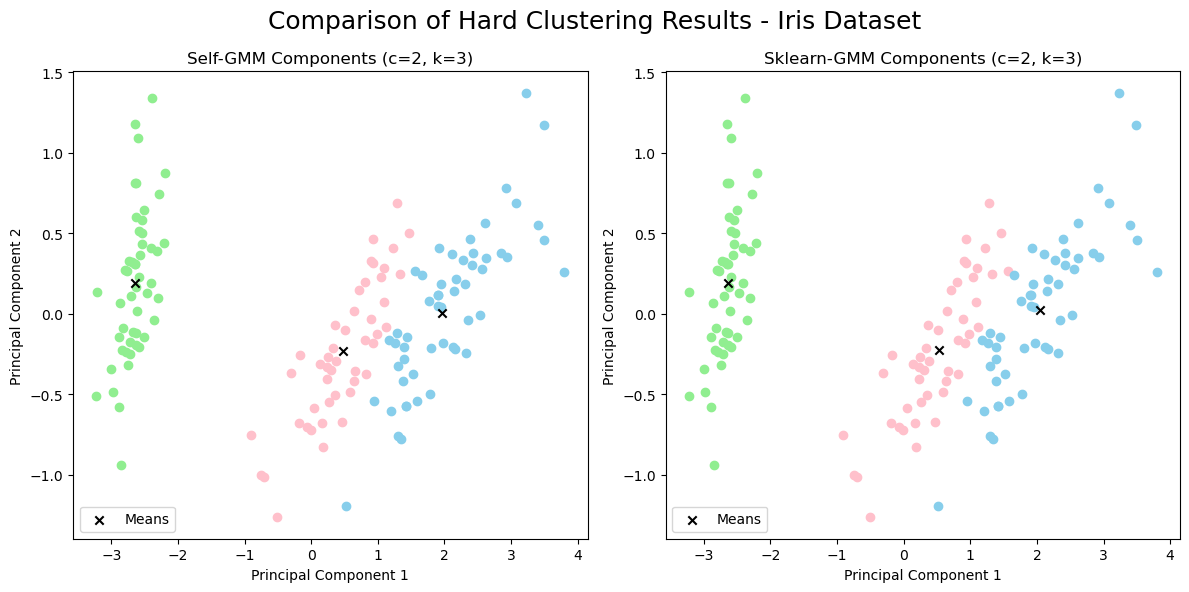

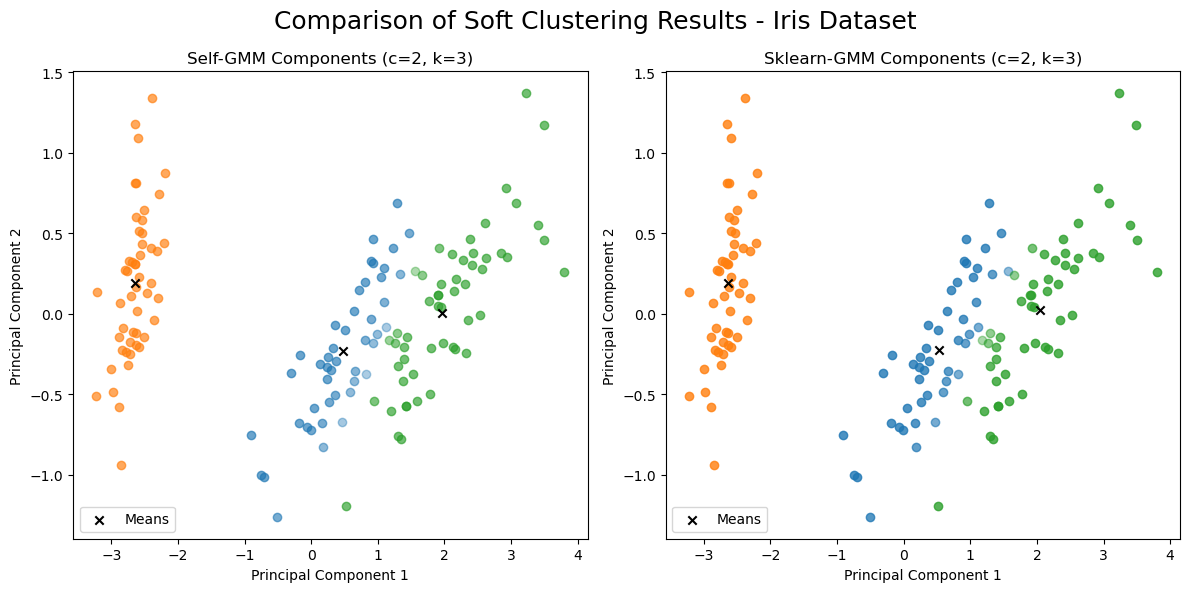

In [133]:
# load wine dataset
iris_data = load_iris()
X = iris_data.data
y = iris_data.target

# preprocess the dataset using PCA (from sklearn)
n_components_pca = 2 
pca = PCA(n_components=n_components_pca)
X_pca = pca.fit_transform(X)

# apply our defined GMM on preprocessed data
k_components_gmm = len(np.unique(y)) # find the number of unique classes to determine the number of components
# 0 = {pi, mu, sigma}
mu0, sigma0, pi0 = gmm_em(X_pca, k_components_gmm) 
hard_assignments = predict(X_pca, mu0, sigma0, pi0, soft=False) # hard clusters
soft_assignments = predict(X_pca, mu0, sigma0, pi0, soft=True)  # soft clusters

# apply sklearn's GMM on preprocessed data
gmm = GaussianMixture(n_components=k_components_gmm, random_state=SEED)
gmm.fit(X_pca)
hard_clusters = gmm.predict(X_pca)       # hard clusters
soft_clusters = gmm.predict_proba(X_pca) # soft clusters

#---------------------------------Hard Clustering Visualizations---------------------------------#
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Comparison of Hard Clustering Results - Iris Dataset', fontsize=18)
colors = ['pink', 'lightgreen', 'skyblue', 'red']

# plot for my defined GMM
for k in range(k_components_gmm):
    mask = hard_assignments == k
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], color=colors[k])
axes[0].scatter(mu0[:, 0], mu0[:, 1], color='black', marker='x', label='Means')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].set_title('Self-GMM Components (c=2, k=3)')
axes[0].legend()

colors = ['pink', 'lightgreen', 'skyblue', 'red'] # switch for better comparison
# colors = ['blue','red', 'green'] # switch for better comparison

# plot for sklearn's GMM
for k in range(k_components_gmm):
    mask = hard_clusters == k
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1], color=colors[k])
axes[1].scatter(gmm.means_[:, 0], gmm.means_[:, 1], color='black', marker='x', label='Means')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].set_title('Sklearn-GMM Components (c=2, k=3)')
axes[1].legend()

plt.tight_layout()
plt.show()

#---------------------------------Soft Clustering Visualizations---------------------------------#
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  
fig.suptitle('Comparison of Soft Clustering Results - Iris Dataset', fontsize=18) 


# plot for my defined GMM
for i in range(X_pca.shape[0]):
    # per point, find the most likely cluster and its prob
    cluster = np.argmax(soft_assignments[i])
    probability = soft_assignments[i, cluster]
    # map the probability to the alpha value of the color for visualization
    axes[0].scatter(X_pca[i, 0], X_pca[i, 1], c=plt.cm.tab10(cluster), alpha=100 * probability)
axes[0].scatter(mu0[:, 0], mu0[:, 1], color='black', marker='x', label='Means')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].set_title('Self-GMM Components (c=2, k=3)')
axes[0].legend()

# plot for sklearn's GMM
for i in range(X_pca.shape[0]):
    cluster = np.argmax(soft_clusters[i])
    probability = soft_clusters[i, cluster]
    axes[1].scatter(X_pca[i, 0], X_pca[i, 1], c=plt.cm.tab10(cluster), alpha=0.8 * probability)
axes[1].scatter(gmm.means_[:, 0], gmm.means_[:, 1], color='black', marker='x', label='Means')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].set_title('Sklearn-GMM Components (c=2, k=3)')
axes[1].legend()

plt.tight_layout()
plt.show()



#### Concluding Analysis


As shown through the results of the Wine and Iris dataset, my scratch implementation of the Gaussian Mixture Model was able to successfully cluster the data points into their respective clusters. The results of my implementation were also comparable to the results of the built-in `GaussianMixture` model from the `sklearn` library; we cam see that my implementation is not too far off from sklearn's built-in version. There are minor differences where we can see that some data points are assigned to different clusters and the cluster centers are slightly different. Overall, the results are very similar whenever my model is given a $K$ component value that is the exact number of classes from the provided dataset. 

On the other hand, whenever I increase the number of $K$ components to a value that is greater than the number of classes in the dataset, the results from both my implementation and sklearn's implementation are very different. Here are some hard-clustered visualizations of the results of my implementation and sklearn's built-in `GaussianMixture` model when $K$ is set to 4 for the Wine dataset and 4 for the Iris dataset (one more than the number of classes in both of these dataset):

![Wine Dataset - k=4](4kwine.png){ width=65% }

![Iris Dataset - k=4](4kiris.png){ width=65% }

Assuming that scikit-learn's implementation is more accurate than mine, we can observe that increasing the number of components to a value greater than the number of classes in the dataset results in additional clusters that separate the classes with the most intra-class differences. 

On a brighter note, the outcomes of changing the number of $c$ principal components (in my case, I chose to visualize the differing results when we change $c$ from 2 to 3, as it's the best way to visualize the results) are similar between my implementation and sklearn's built-in model. Here are some hard-clustered visualizations of the results from both my implementation and sklearn's built-in model when $c$ is set to 3 for the Wine dataset and 3 for the Iris dataset (*the code to generate these visualizations is provided at the very end of the notebook*):

![Wine Dataset - c=3](3cwine.png){ width=65% }

![Iris Dataset - c=3](3ciris.png){ width=65% }


When thinking about what factors could have contributed to the differences in the results, I can only name one at the top of my head: the criteria I used to converge my EM algorithm implementation. I used a fixed number of iterations to terminate the EM algorithm, which is the most common and intuitive way to do it. However, there is a better way to do it which is to use the log-likelihood to determine when to stop the EM algorithm. This is because the log-likelihood is a measure of how well the model fits the data, and it increases as the model gets better. Therefore, we can use the log-likelihood to determine when the model has converged. This is a better way to determine when to stop the EM algorithm because it is more objective and data-driven. I have a strong feeling that sklearn's built-in `GaussianMixture` model uses a criteria like this to determine when to stop the EM algorithm, which is why the results are slightly different.


### Extra Code (used for generating 3D visualizations of the results when PCA components is set to 3)


In [134]:
def plot_sklearn_gmm_pca(dataset, title, ax):
    X = dataset.data
    y = dataset.target

    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    k_components_gmm = len(np.unique(y)) # find the number of unique classes to determine the number of components

    gmm = GaussianMixture(n_components=k_components_gmm, random_state=SEED)
    gmm.fit(X_pca)
    hard_clusters = gmm.predict(X_pca)

    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=hard_clusters, cmap='viridis', label='Samples')
    cluster_centers = gmm.means_
    ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], 
               s=80, marker='*', c='red', label='Cluster Means')

    ax.legend()
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(title)

def plot_self_gmm_pca(dataset, title, ax):
    X = dataset.data
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    k_components_gmm = len(np.unique(y)) # find the number of unique classes to determine the number of components

    mu0, sigma0, pi0 = gmm_em(X_pca, k_components_gmm) 
    hard_assignments = predict(X_pca, mu0, sigma0, pi0, soft=False) 

    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=hard_assignments, cmap='viridis', label='Samples')
    ax.scatter(mu0[:, 0], mu0[:, 1], mu0[:, 2], 
               s=80, marker='*', c='red', label='Cluster Means')

    ax.legend()
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(title)

# Load datasets
wine = load_wine()
iris = load_iris()

# -------UNCOMMENT THESE LINES TO RUN THE 3D PLOTS--------

# # Create a figure for 3D plots
# fig = plt.figure(figsize=(16, 8))
# fig.suptitle('Comparison of Hard Clustering Results - Iris Dataset', fontsize=18)

# # Subplot for Wine dataset
# ax1 = fig.add_subplot(121, projection='3d')
# plot_self_gmm_pca(iris, 'Self-GMM Components (c=3, k=3)', ax1)

# # Subplot for Iris dataset
# ax2 = fig.add_subplot(122, projection='3d')
# plot_sklearn_gmm_pca(iris, 'Sklearn-GMM Components (c=3, k=3)', ax2)

# plt.show()
